# HomeWork #5

## Machine Learning and pattern recognition

### Malihe Ghazalian
###### STD.No. : 830402056

In [1]:
#dataloading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision import transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_dir = "kaggle.com/datasets/zalando-research/fashionmnist"

#Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

#Define training and test set
train_set = datasets.FashionMNIST(data_dir, download=True, train=True, transform = transform)
test_set = datasets.FashionMNIST(data_dir, download=True, train=False, transform = transform)

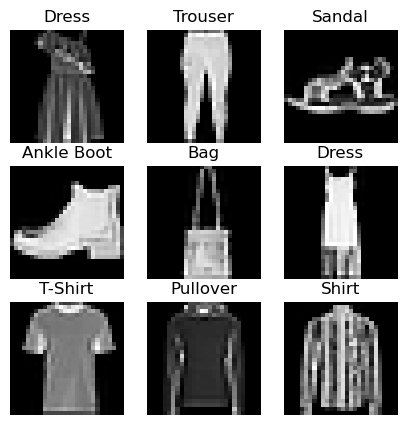

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Defining Transformations:

#### transforms.ToTensor(): 
Converts the images into PyTorch tensors and scales the pixel values to the range [0, 1].

#### transforms.Normalize((0.5,), (0.5,)): 
Normalize a tensor image with mean and standard deviation. Normalizes the tensor images so that each pixel value is centered around 0 and falls within the range [-1, 1]. This normalization helps in stabilizing the learning process and often leads to faster convergence in deep learning models.

### Split data
split train set into validation set (10% of train set) and train set

In [ ]:
#Data split to create validation set: 10% of training data
# generator = torch.Generator().manual_seed(42)
# train_set, valid_set = random_split(train_set, [50000, 10000], generator=generator)

### DataLoader
The DataLoader in PyTorch provides batches of data, and you can iterate through these batches to collect all images and labels. This method is memory-efficient and is typically used when dealing with large datasets

In [5]:
# Create data loaders for our datasets
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)
# validloader = DataLoader(valid_set, batch_size=32, shuffle=True)

### Define image lables

In [6]:
def images_lables(loader):
    images = []
    labels = []
    
    for batch in loader:
        b_images, b_labels = batch
        images.append(b_images)
        labels.append(b_labels)
    return torch.cat(images, dim=0), torch.cat(labels, dim=0)

In [7]:
train_images, train_lables = images_lables(trainloader)
test_images, test_lables = images_lables(testloader)
# valid_images, valid_lables = images_lables(validloader)

In [8]:
print(train_images.shape, "\n")
print(len(train_lables))

torch.Size([60000, 1, 28, 28]) 

60000


# CNN

In [9]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        #Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, (3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, (3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 64, (3,3))
        )
        
        #Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*3*3, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    #Forward Propagation Step
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [10]:
model = CNN_model().to(device)

In [11]:
#Define Loss function and optimizer
Loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train model

In [12]:
for epoche in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        image, label = data
        image = image.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        
        #forward propagation
        output = model(image)
        loss = Loss_fn(output, label)
        
        #backward propagation
        loss.backward()
        optimizer.step()
        
        #print loss for every 2000 batch
        running_loss += loss.item()

print("Training is finished")

Training is finished


In [13]:
print(running_loss/60000)

0.016859786196798086


### Testing on test set

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        values, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (
    100 * correct / total))

Accuracy: 80 %


### Predict on some test data
from one batch of test-set choose 8 images from and predict image label

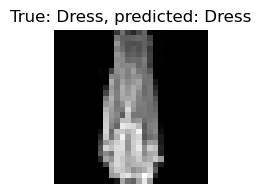

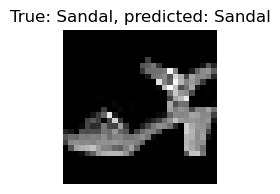

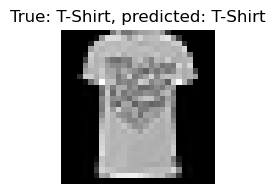

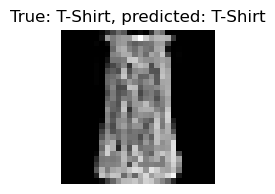

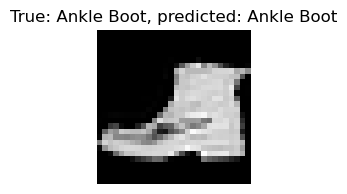

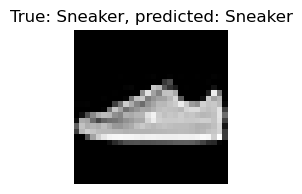

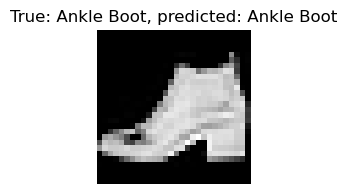

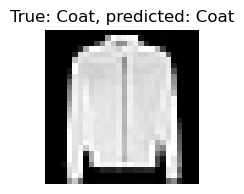

In [15]:
with torch.no_grad():
    for i, batch in enumerate(testloader):
        if i == 100:
            test_images, test_labels = batch
            test_labels = test_labels.to(device)
            test_images = test_images.to(device)
            exp_out = model(test_images)
            _, exp_label_predict = torch.max(exp_out.data, 1)
            for i in range(1,9):
                figure = plt.figure(figsize=(2, 2))
                title = "True: "+labels_map[test_labels[i].item()]+", predicted: "+labels_map[exp_label_predict[i].item()]
                plt.title(title)
                plt.axis("off")
                plt.imshow(test_images[i].cpu().numpy().squeeze(), cmap="gray")
                plt.show()

# MLP implementation

In [16]:
# Create data loaders for our datasets
trainloader = DataLoader(train_set, batch_size=100, shuffle=True)
testloader = DataLoader(test_set, batch_size=100, shuffle=True)

In [17]:
class MLP_classifier(nn.Module):
    def __init__(self):
        super(MLP_classifier, self).__init__()
        self.linear1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        return out

In [18]:
mlp_model = MLP_classifier().to(device)

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=0.001, momentum=0.9)

### Train MLP model on training set

In [20]:
for epoch in range(5):
    for i, batch in enumerate(trainloader):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        #Forward
        train_out = mlp_model(images)
        train_loss = loss_fn(train_out, labels)
        
        #Backward
        train_loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/2], Step [{i+1}/{len(trainloader)}], Loss: {train_loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 2.0245
Epoch [1/2], Step [200/600], Loss: 1.3602
Epoch [1/2], Step [300/600], Loss: 1.1092
Epoch [1/2], Step [400/600], Loss: 0.8376
Epoch [1/2], Step [500/600], Loss: 0.7204
Epoch [1/2], Step [600/600], Loss: 0.6822
Epoch [2/2], Step [100/600], Loss: 0.7122
Epoch [2/2], Step [200/600], Loss: 0.6112
Epoch [2/2], Step [300/600], Loss: 0.6605
Epoch [2/2], Step [400/600], Loss: 0.5384
Epoch [2/2], Step [500/600], Loss: 0.6654
Epoch [2/2], Step [600/600], Loss: 0.6757
Epoch [3/2], Step [100/600], Loss: 0.5983
Epoch [3/2], Step [200/600], Loss: 0.5767
Epoch [3/2], Step [300/600], Loss: 0.5446
Epoch [3/2], Step [400/600], Loss: 0.5112
Epoch [3/2], Step [500/600], Loss: 0.5259
Epoch [3/2], Step [600/600], Loss: 0.6517
Epoch [4/2], Step [100/600], Loss: 0.6204
Epoch [4/2], Step [200/600], Loss: 0.4938
Epoch [4/2], Step [300/600], Loss: 0.5466
Epoch [4/2], Step [400/600], Loss: 0.5277
Epoch [4/2], Step [500/600], Loss: 0.4664
Epoch [4/2], Step [600/600], Loss:

The accuracy for MLP with one hidden layer compare to CNN was literaly lower but with 2 hidden layer and increase epoches make it's MLP accuracy better, equal to CNN.

### evaluate trained model on test data

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = mlp_model(images)
        values, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (
    100 * correct / total))

Accuracy: 82 %


### Predict on some images of test data

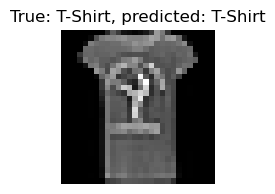

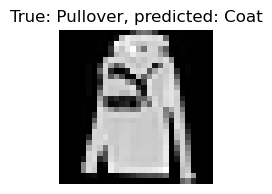

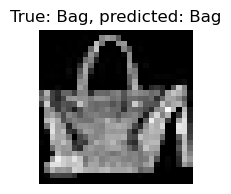

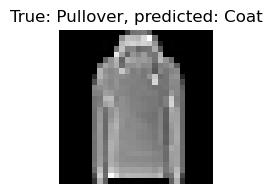

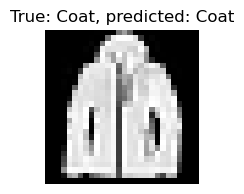

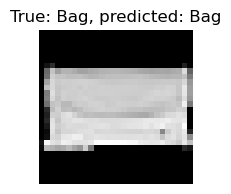

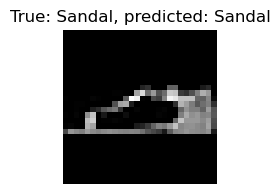

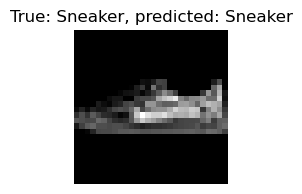

In [22]:
with torch.no_grad():
    for i, batch in enumerate(testloader):
        if i == 50:
            test_images, test_labels = batch
            test_labels = test_labels.to(device)
            test_images = test_images.to(device)
            exp_out = mlp_model(test_images)
            _, exp_label_predict = torch.max(exp_out.data, 1)
            for i in range(1,9):
                figure = plt.figure(figsize=(2, 2))
                title = "True: "+labels_map[test_labels[i].item()]+", predicted: "+labels_map[exp_label_predict[i].item()]
                plt.title(title)
                plt.axis("off")
                plt.imshow(test_images[i].cpu().numpy().squeeze(), cmap="gray")
                plt.show()

# EDA

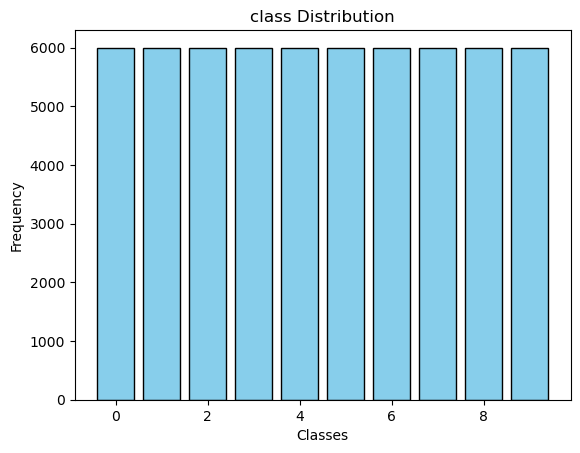

In [23]:
#distribution of classes in dataset
classes, counts = np.unique(train_lables.numpy(), return_counts=True)
plt.bar(classes, counts, edgecolor='k', color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('class Distribution')
plt.show()

All classes have same frequencies equal to 6000, and all bar's height have the same so classes are balanced.

In [78]:
pixel_mean_arr = {}
for i, img in enumerate(train_images):
    pixel_mean = torch.mean(img)
    pixel_mean_arr[i] = pixel_mean.item()

In [84]:
pixel_std_arr = {}
for i, img in enumerate(train_images):
    pixel_std = torch.std(img)
    pixel_std_arr[i] = pixel_std.item()

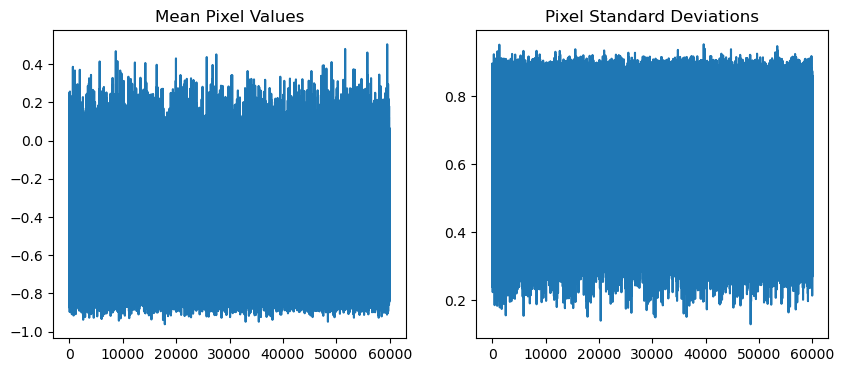

In [85]:
# Visualize mean and standard deviation
mean_keys = list(pixel_mean_arr.keys())
mean_values = list(pixel_mean_arr.values())

std_keys = list(pixel_std_arr.keys())
std_values = list(pixel_std_arr.values())

# plt.scatter(keys, values)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(mean_values)
plt.title('Mean Pixel Values')
plt.subplot(1, 2, 2)
plt.plot(std_values)
plt.title('Pixel Standard Deviations')
plt.show()

### Attentionin transformer

# Report

## Implementation reports

1- for CNN model we use cross entropy loss and SGD optimizer for find optimal parameters. model designed with 3 convolutional layers an 2 of pooling layers, feed output to linear layers, the accuracy on test data is 82% with.
find dimention of tensor which feeded to linear layers was challenging here also by increasing epoches during training accuracy get better but it took more time. also split training data to train and validation data make accuracy even more but i think it is because smaller amount of data may lead to overfitting. so i decided to don't use of validation set and compute accuracy and test model on trainig set which was provided before.
2- for MLP using relu activation function make accuracy better compared to sigmoid, changing number of neurons doesnt change accuracy too much but increasing hidden layer from 1 to 2 make it better, by increasing number of epoches, accuracy on test data improved and became similar to the accuracy in CNN model with 1 hidden layer. changing batch size does'nt really change the performance. the loss i use was cross entropy and use SGD optimizer to find optimal parameters during backpropagation.

## Theory part questions:

1 – If model is to deep because error must pass through several layers, it may couse amplify or diminish it, and gradient could be too small which is vanishing problem or too large which is exploding problem, to solve it we can consider following solutions:
	Modify activation function to prevent at each layer gradient becoming too small or too large
	Modify architecture which can make updates to become additive rather than multiplicative
	Modify architecture to standardize activation function at each layer that so distribution activations on dataset remaining constant during training
	Carefully choose the initial parameters
2 – Batch normalization is a technique using in deep neural network to find best transformation of data to help the network overcome the unstable gradient problems. The idea behind it is to feed normalized input into next layer of network, because after a output of nonlinear function would not be standardized and normalized, by standardize we mean to make mean of data to zero and variance to 1 and by normalization we mean scale data to a certain domain. And so before every layer we can standardize batch of data and normalizing it with two learnable parameters (gamma and beta) during batch training .
z^((i))=ϒx ̂^((i)) + β
the benefit of using batch normalization is:
	Gaining better parameters during epochs take long due to the amount of computation
	Achieve same accuracy faster
	Can lead to better performance
	Reduce the need for other regularization (to overcome overfitting) 
3 – dropout is a regularization technique to prevent overfitting which prevents complex co-adaptation of hidden units during training a batch. if we randomly turn off all outgoing connection from each neuron with probability p, this is called dropout (neurons are not fully connected) which could reduce overfitting. The idea is each unit must perform well even if others were missing at random which produce noises during training. The dropout probability is a hyperparameter that determine the fracture of neurons to be dropped out during training. The common dropout probability range between 0.2 to 0.5.

## ATTENTION In Transformers Theory:

In the context of transformer architecture, the attention matrix, often referred to as the attention weight matrix or attention scores, plays a crucial role in determining how much attention each element in a sequence should pay to every other element. Transformer networks almost exclusively use attention blocks. Attention helps to draw connections between any parts of the sequence, so long-range dependencies are not a problem anymore. With transformers, long-range dependencies have the same likelihood of being taken into account as any other short-range dependencies. There is little to no gradient vanishing or explosion problem. In Transformer networks, the entire sequence is trained simultaneously, and to build on that only a few more layers are added. So gradient vanishing or explosion is rarely an issue. And Requires fewer steps to train than an RNN.
We can think of attention as a dictionary lookup, in which we compare the query q to each key ki, and then retrieve the corresponding value vi. To make this lookup operation differentiable, instead of retrieving a single value vi,
For each position in the sequence, the model computes attention scores by taking the dot product of the Query vector of that position with the Key vectors of all positions. These scores are then scaled and passed through a softmax function to obtain attention weights that sum up to 1.